# Esquema del modelo definitivo

## I. Librerias y funciones

In [1]:
#Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Función para convertir los datos en secuencias de tiempo
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

## II. Procesado del DF

In [50]:
#Covid transofromar en niveles de restricciones
df = pd.read_csv('../data/DF_modelos/df_residencial_total.csv')
df

,Sector_Economic,año,consumo,fecha,findesemana,festivos,lectivos,COVID,tmed,prec,velmedia,poblacion,PIB,Rentanetamediaporpersona,Rentanetamediaporhogar,bono_social
0,Residencial,2019.0,6713701,2019-01-01,0,1,0,0,8.590909,0.0,1.417647,5628011,62490,14656.0,38386.00,0
1,Residencial,2019.0,7354663,2019-01-02,0,0,0,0,6.617391,0.3,2.152941,5628011,62490,14656.0,38386.00,0
2,Residencial,2019.0,7619413,2019-01-03,0,0,0,0,5.604348,0.1,1.676471,5628011,62490,14656.0,38386.00,0
3,Residencial,2019.0,7815514,2019-01-04,0,0,0,0,5.004348,0.0,1.335294,5628011,63436,14656.0,38386.00,0
4,Residencial,2019.0,7527041,2019-01-05,1,0,0,0,6.173913,0.0,2.247059,5628011,62490,14656.0,38386.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,Residencial,2024.0,5404940,2024-06-26,0,0,0,0,22.623810,0.0,2.168750,5884873,77268,17845.0,45903.93,1
2004,Residencial,2024.0,5326951,2024-06-27,0,0,0,0,23.776190,0.0,1.912500,5884873,77268,17845.0,45903.93,1
2005,Residencial,2024.0,5490645,2024-06-28,0,0,0,0,24.452381,15.5,2.637500,5884873,77268,17845.0,45903.93,1
2006,Residencial,2024.0,5137699,2024-06-29,1,0,0,0,20.942857,223.6,2.050000,5884873,77268,17845.0,45903.93,1


In [51]:
df = df.drop(columns=['Sector_Economic','año','COVID','festivos','prec','velmedia','Rentanetamediaporpersona','Rentanetamediaporhogar','bono_social','poblacion','lectivos']) 

In [52]:
#Analizar los valores de df
df

,consumo,fecha,findesemana,tmed,PIB
0,6713701,2019-01-01,0,8.590909,62490
1,7354663,2019-01-02,0,6.617391,62490
2,7619413,2019-01-03,0,5.604348,62490
3,7815514,2019-01-04,0,5.004348,63436
4,7527041,2019-01-05,1,6.173913,62490
...,...,...,...,...,...
2003,5404940,2024-06-26,0,22.623810,77268
2004,5326951,2024-06-27,0,23.776190,77268
2005,5490645,2024-06-28,0,24.452381,77268
2006,5137699,2024-06-29,1,20.942857,77268


In [53]:
#Eliminar consumos anomalos
index_primera_menor_1000 = df[df['consumo'] < 200000].index.min()

# Eliminar todas las filas desde ese índice en adelante
if index_primera_menor_1000 is not None:
    df = df.loc[:index_primera_menor_1000-1]

df

,consumo,fecha,findesemana,tmed,PIB
0,6713701,2019-01-01,0,8.590909,62490
1,7354663,2019-01-02,0,6.617391,62490
2,7619413,2019-01-03,0,5.604348,62490
3,7815514,2019-01-04,0,5.004348,63436
4,7527041,2019-01-05,1,6.173913,62490
...,...,...,...,...,...
1943,4803374,2024-04-27,1,14.108696,77268
1944,5117827,2024-04-28,1,12.460870,77268
1945,5699315,2024-04-29,0,11.617391,77268
1946,5269315,2024-04-30,0,13.543478,77268


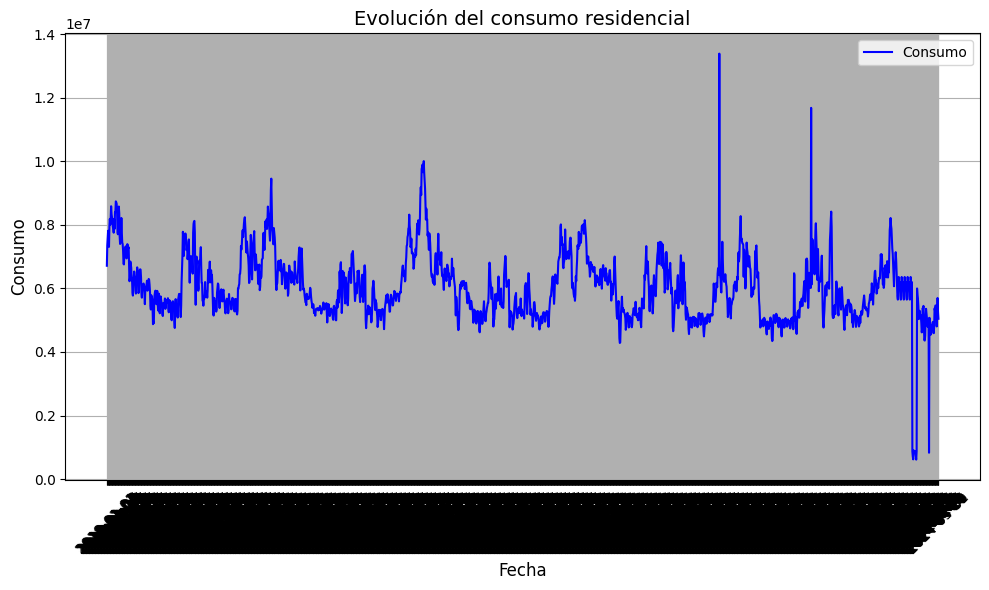

In [54]:
# Crear la gráfica temporal
plt.figure(figsize=(10,6))
plt.plot(df['fecha'], df['consumo'], label='Consumo', color='b')

# Personalizar el gráfico
plt.title('Evolución del consumo residencial', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Consumo', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas de fechas si son muchas
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [55]:
#Consumo previo 3 dias
df['t-1'] = df['consumo'].shift(1)
#df['t-2'] = df['consumo'].shift(2)
#df['t-3'] = df['consumo'].shift(3)

C:\Users\minip\AppData\Local\Temp\ipykernel_13916\137677528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t-1'] = df['consumo'].shift(1)


In [56]:
#Eliminar filas con valores nulos
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

C:\Users\minip\AppData\Local\Temp\ipykernel_13916\3104895913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,consumo,fecha,findesemana,tmed,PIB,t-1
0,7354663,2019-01-02,0,6.617391,62490,6713701.0
1,7619413,2019-01-03,0,5.604348,62490,7354663.0
2,7815514,2019-01-04,0,5.004348,63436,7619413.0
3,7527041,2019-01-05,1,6.173913,62490,7815514.0
4,7308657,2019-01-06,1,9.130435,63436,7527041.0
...,...,...,...,...,...,...
1942,4803374,2024-04-27,1,14.108696,77268,5167220.0
1943,5117827,2024-04-28,1,12.460870,77268,4803374.0
1944,5699315,2024-04-29,0,11.617391,77268,5117827.0
1945,5269315,2024-04-30,0,13.543478,77268,5699315.0


In [57]:
#Formatear 
df['COVID'].replace(2,3,inplace=True)
df['COVID'].replace(1,2,inplace=True)
df['COVID'].replace(3,1,inplace=True)

KeyError: 'COVID'

In [58]:
df.dtypes

consumo          int64
fecha           object
findesemana      int64
tmed           float64
PIB              int64
t-1            float64
dtype: object

In [59]:
df.nunique()

consumo        1917
fecha          1947
findesemana       2
tmed           1847
PIB              22
t-1            1917
dtype: int64

In [60]:
df.shape

(1947, 6)

In [61]:
# Asegúrate de que la columna de fecha está en formato datetime
# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias

In [62]:
df

,consumo,fecha,findesemana,tmed,PIB,t-1
0,7354663,1546387200,0,6.617391,62490,6713701.0
1,7619413,1546473600,0,5.604348,62490,7354663.0
2,7815514,1546560000,0,5.004348,63436,7619413.0
3,7527041,1546646400,1,6.173913,62490,7815514.0
4,7308657,1546732800,1,9.130435,63436,7527041.0
...,...,...,...,...,...,...
1942,4803374,1714176000,1,14.108696,77268,5167220.0
1943,5117827,1714262400,1,12.460870,77268,4803374.0
1944,5699315,1714348800,0,11.617391,77268,5117827.0
1945,5269315,1714435200,0,13.543478,77268,5699315.0


## III. Analisis de variables potenciales

In [63]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo'])  
y = df['consumo']  

test_size_percentage = 0.09
split_index = int(len(X) * (1 - test_size_percentage))

# Dividir en conjunto de entrenamiento (primera parte) y prueba (última parte)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [64]:
#Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
# Modelo para seleccion de caracteristicas importantes
# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (RMSE) como métrica de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Obtener la importancia de las características
importancia = model_xgb.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia*100})
feature_importance = feature_importance.sort_values(by='Importancia', ascending=False)
# Mostrar las variables ordenadas por importancia
print(feature_importance)

RMSE: 1153578.852653748
      Variable  Importancia
4          t-1    86.215355
2         tmed     5.467726
1  findesemana     4.123895
3          PIB     2.208431
0        fecha     1.984598


C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [67]:
# convertir de array a pandas para el VIF
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_train_selected = df_X_train_scaled[['findesemana', 't-1', 'tmed', 'fecha','PIB']]
df_X_train_selected

,findesemana,t-1,tmed,fecha,PIB
0,-0.632456,0.658950,-1.391208,-1.731073,-0.324258
1,-0.632456,1.325940,-1.545792,-1.729117,-0.324258
2,-0.632456,1.601442,-1.637348,-1.727161,-0.166267
3,1.581139,1.805506,-1.458879,-1.725205,-0.324258
4,1.581139,1.505318,-1.007733,-1.723249,-0.166267
...,...,...,...,...,...
1766,-0.632456,-0.868453,-0.601038,1.723249,1.695217
1767,1.581139,-0.821020,-0.363522,1.725205,1.695217
1768,1.581139,-0.944644,-0.266659,1.727161,1.695217
1769,-0.632456,-0.876637,-0.523414,1.729117,1.695217


In [68]:
#Test VIF
vif = pd.Series([variance_inflation_factor(df_X_train_selected.corr().values, i) for i in range(df_X_train_selected.corr().shape[1])], index=df_X_train_selected.columns)
vif

findesemana     1.030767
t-1             2.189669
tmed            1.805922
fecha          16.653785
PIB            15.266375
dtype: float64

In [69]:
# Correlacion individual
correlation_matrix = df.corr()
# Mostrar la matriz de correlación
print(correlation_matrix)

              consumo         fecha   findesemana      tmed       PIB  \
consumo      1.000000 -2.800294e-01 -1.508837e-01 -0.302511 -0.212102   
fecha       -0.280029  1.000000e+00 -7.275926e-16  0.038807  0.823911   
findesemana -0.150884 -7.275926e-16  1.000000e+00  0.005142 -0.004563   
tmed        -0.302511  3.880673e-02  5.142396e-03  1.000000  0.008235   
PIB         -0.212102  8.239115e-01 -4.562689e-03  0.008235  1.000000   
t-1          0.897264 -2.798032e-01 -8.115616e-02 -0.294749 -0.213318   

                  t-1  
consumo      0.897264  
fecha       -0.279803  
findesemana -0.081156  
tmed        -0.294749  
PIB         -0.213318  
t-1          1.000000  


## IV. Modelo LSTM

### IV.I. Preparar datos

In [70]:
#Ordenar los datos cronologicamnte
df = df.sort_values(by='fecha')

In [71]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo','fecha'])  
y = df['consumo']

In [72]:
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [73]:
# Dividir en conjunto de entrenamiento y prueba (manteniendo el orden temporal)
train_size = int(len(X) * 0.9)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [74]:
X_train

array([[0.        , 0.17305586, 0.47159152, 0.47750606],
       [0.        , 0.13898399, 0.47159152, 0.52766622],
       [0.        , 0.11880408, 0.5054171 , 0.54838492],
       ...,
       [0.        , 0.57753139, 0.90395824, 0.35787951],
       [0.        , 0.65459524, 0.90395824, 0.35876022],
       [0.        , 0.57799097, 0.90395824, 0.36837542]])

In [75]:
X_test

array([[0.00000000e+00, 5.09680107e-01, 9.03958236e-01, 3.61944918e-01],
       [1.00000000e+00, 4.32908722e-01, 9.03958236e-01, 3.47572046e-01],
       [1.00000000e+00, 4.13459971e-01, 9.03958236e-01, 3.26982154e-01],
       [0.00000000e+00, 5.86743955e-01, 9.03958236e-01, 3.31753912e-01],
       [0.00000000e+00, 4.88184119e-01, 9.03958236e-01, 3.53715112e-01],
       [0.00000000e+00, 5.13774581e-01, 9.03958236e-01, 3.48779639e-01],
       [0.00000000e+00, 5.92739434e-01, 9.03958236e-01, 3.46990826e-01],
       [0.00000000e+00, 4.94910755e-01, 9.03958236e-01, 3.49165684e-01],
       [1.00000000e+00, 4.94033368e-01, 9.03958236e-01, 3.42770784e-01],
       [1.00000000e+00, 5.02953472e-01, 9.03958236e-01, 3.27924141e-01],
       [0.00000000e+00, 4.69466525e-01, 9.03958236e-01, 3.32245370e-01],
       [0.00000000e+00, 3.71365324e-01, 9.03958236e-01, 3.53806830e-01],
       [0.00000000e+00, 4.05124792e-01, 9.03958236e-01, 3.36672873e-01],
       [0.00000000e+00, 4.21063994e-01, 9.03958236e

In [76]:
# Crear secuencias de tiempo para LSTM
time_steps = 10  # Esto significa que la predicción se basará en los últimos 10 días
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)
print(f"Forma de X_train_seq: {X_train_seq.shape}")  # Debe ser (samples, time_steps, features)

Forma de X_train_seq: (1742, 10, 4)


### IV.II. Definir modelo LSTM

In [77]:
# Definir el modelo LSTM
model = Sequential()

In [78]:
# Primera capa LSTM con 50 unidades y dropout para regularización
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
# Segunda capa LSTM
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
# Capa de salida para la predicción continua de la demanda de electricidad
model.add(Dense(1))

C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [79]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [80]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

### IV.III Entrenamiento del Modelo

In [81]:
# Entrenamiento conm 100 epocas
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0228 - val_loss: 0.0088
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0089
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0086
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0085
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0083
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0083
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0080
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0078
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

### IV.IV. Evaluacion del Modelo

In [82]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Loss: {loss}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032    
Loss: 0.00554741220548749


In [83]:
#Comprobar la prediccion
# Predecir los valores de prueba
y_pred_scaled = model.predict(X_test_seq)
# Desescalar las predicciones y los valores reales para comparar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)
# Comparar las primeras predicciones con los valores reales
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_true[:5].flatten()}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Predicciones: [5110864.5 5125134.5 5148888.5 5052502.  4911381. ]
Valores reales: [5133034. 4914091. 5140643. 5245903. 5291485.]


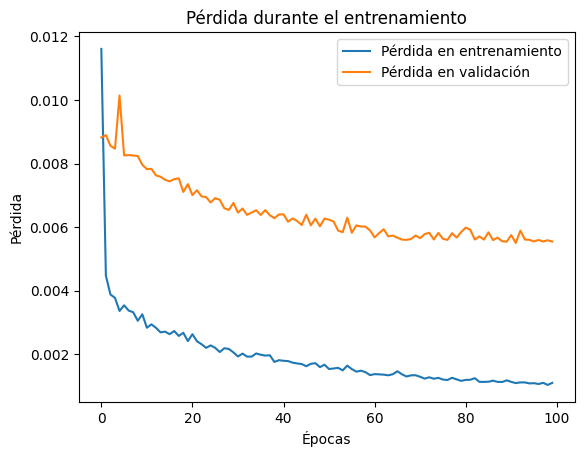

In [84]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## V. Guardar modelo no vaya a ser que se nos borre 

In [85]:
#Extraccion del modelo en la carpeta modelos
model.save('../models/modelo_residencial_Def.h5')